In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [49]:
#Generate example time series data
np.random.seed(0)
dates = pd.date_range(start='1990-01-01', periods=100, freq='M') #Make a column of dates
dates = pd.to_datetime(dates) #Tell Pandas to treat the column as a datetime object
values = np.cumsum(np.random.randn(100))
df = pd.DataFrame({'Date': dates, 'Value': values})
df.set_index('Date', inplace=True) 

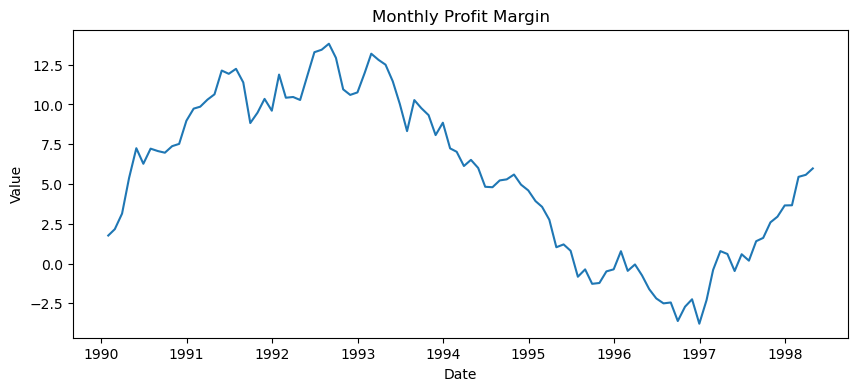

In [51]:
#Plot the time series data
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Value'])
plt.title('Monthly Profit Margin')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

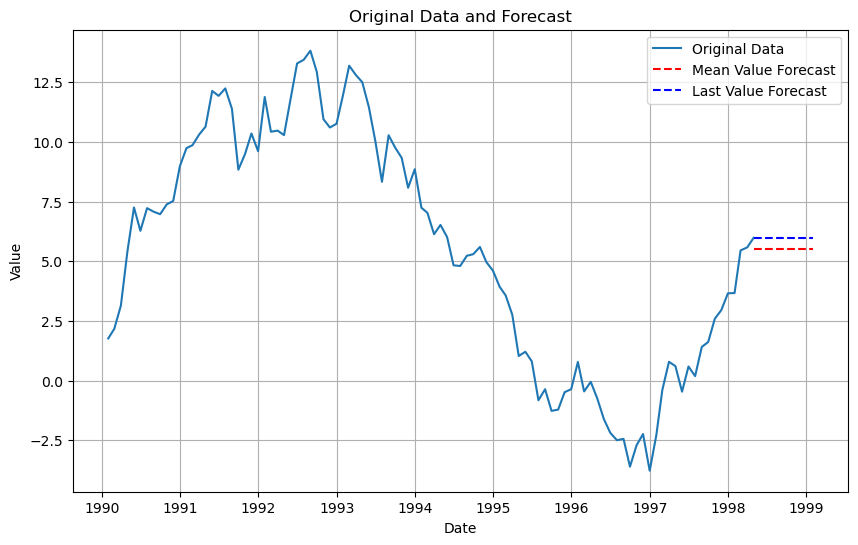

In [63]:
#Simple Forecasting Methods
mean_forecast = [df['Value'].mean()] * 10
last_value_forecast = [df['Value'].iloc[-1]] * 10

#n = len(df)
#drift = (df['Value'].iloc[-1] - df['Value'].iloc[0]) / n
#drift_forecast = [df['Value'].iloc[-1] + drift * i for i in range(1, 11)]

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Value'], label='Original Data')
plt.plot(pd.date_range(start=df.index[-1], periods=10, freq='M'), mean_forecast, color='red', linestyle='--', label='Mean Value Forecast')
plt.plot(pd.date_range(start=df.index[-1], periods=10, freq='M'), last_value_forecast, color='blue', linestyle='--', label='Last Value Forecast')
#plt.plot(pd.date_range(start=df.index[-1], periods=10, freq='M'), drift_forecast, color='purple', linestyle='--', label='Drift Forecast')

plt.title('Original Data and Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Value')

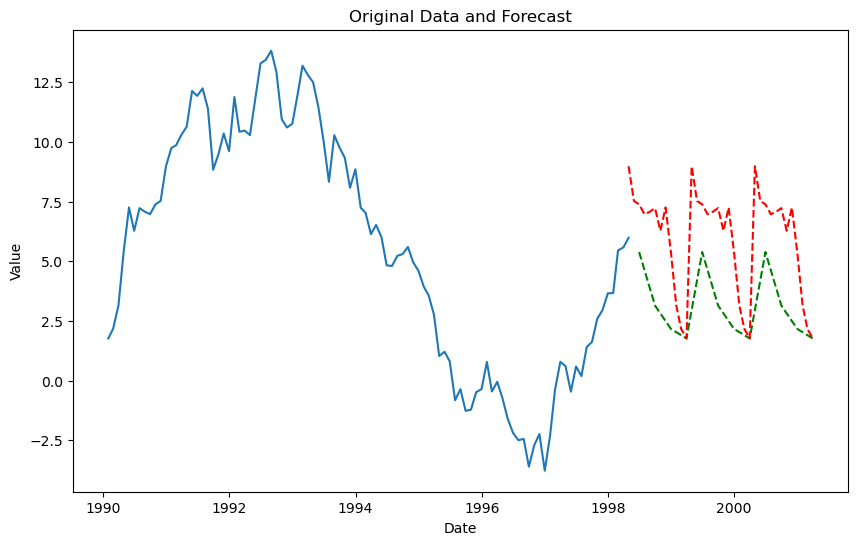

In [54]:
seasonal_naive_forecast_q = []
for i in range(12):
    prev_season_value_q = df['Value'].iloc[-(i + 1) % 4]  #Get the value from the same quarter of the previous year
    seasonal_naive_forecast_q.append(prev_season_value_q)

seasonal_naive_forecast_m = []
for i in range(36):
    prev_season_value_m = df['Value'].iloc[-(i + 1) % 12]  #Get the value from the same quarter of the previous year
    seasonal_naive_forecast_m.append(prev_season_value_m)


plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Value'], label='Original Data')
plt.plot(pd.date_range(start=df.index[-1], periods=12, freq='Q'), seasonal_naive_forecast_q, color='green', linestyle='--', label='Seasonal Naive Forecast - Quarterly')
plt.plot(pd.date_range(start=df.index[-1], periods=36, freq='M'), seasonal_naive_forecast_m, color='red', linestyle='--', label='Seasonal Naive Forecast - Monthly')

plt.title('Original Data and Forecast')
plt.xlabel('Date')
plt.ylabel('Value')

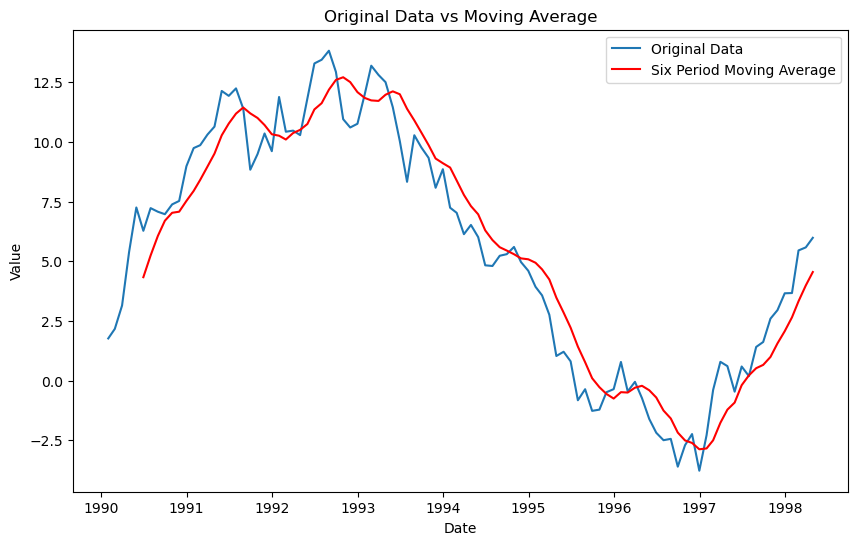

In [74]:
#Calculate a 6 period moving average
window_size = 6
df['Moving_Avg_6'] = df['Value'].rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Value'], label='Original Data')
plt.plot(df.index, df['Moving_Avg_6'], color='red', label='Six Period Moving Average')
plt.title('Original Data vs Moving Average')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

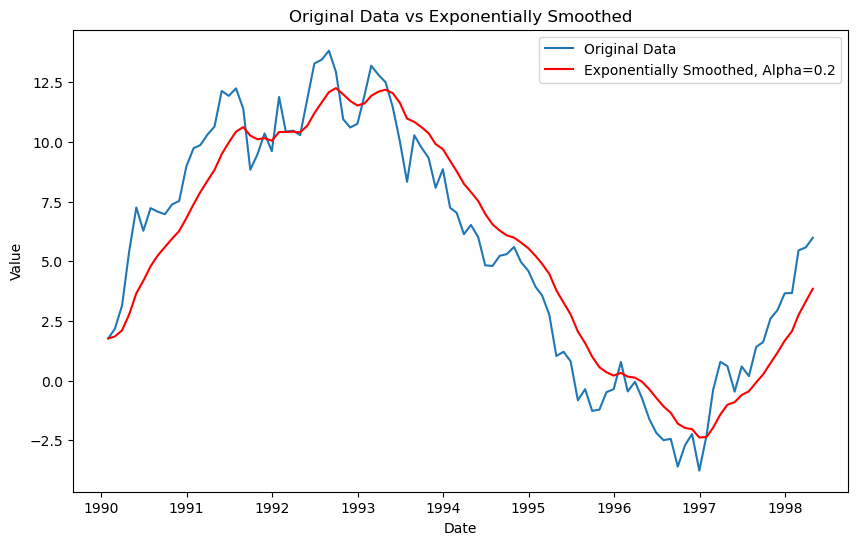

In [84]:
#Exponential Smoothing w/ Pandas
alpha = 0.2  #Smoothing factor
df['Exponential_Smoothed'] = df['Value'].ewm(alpha=alpha, adjust=False).mean()

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Value'], label='Original Data')
plt.plot(df.index, df['Exponential_Smoothed'], color='red', label='Exponentially Smoothed, Alpha=0.2')
plt.title('Original Data vs Exponentially Smoothed')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


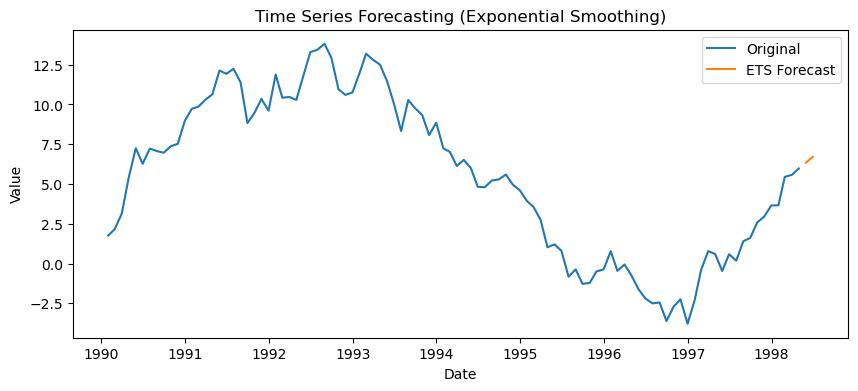

In [33]:
#Exponential Smoothing w/ Statsmodels 
model_ets = sm.tsa.ExponentialSmoothing(df['Value'], trend='add', seasonal='add', seasonal_periods=4)
results_ets = model_ets.fit()
forecast_ets = results_ets.predict(start=100, end=101)

#Plot the original data and the exponential smoothing forecasted values
plt.figure(figsize=(10, 4))
plt.plot(df['Value'], label='Original')
plt.plot(forecast_ets, label='ETS Forecast')
plt.title('Time Series Forecasting (Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()

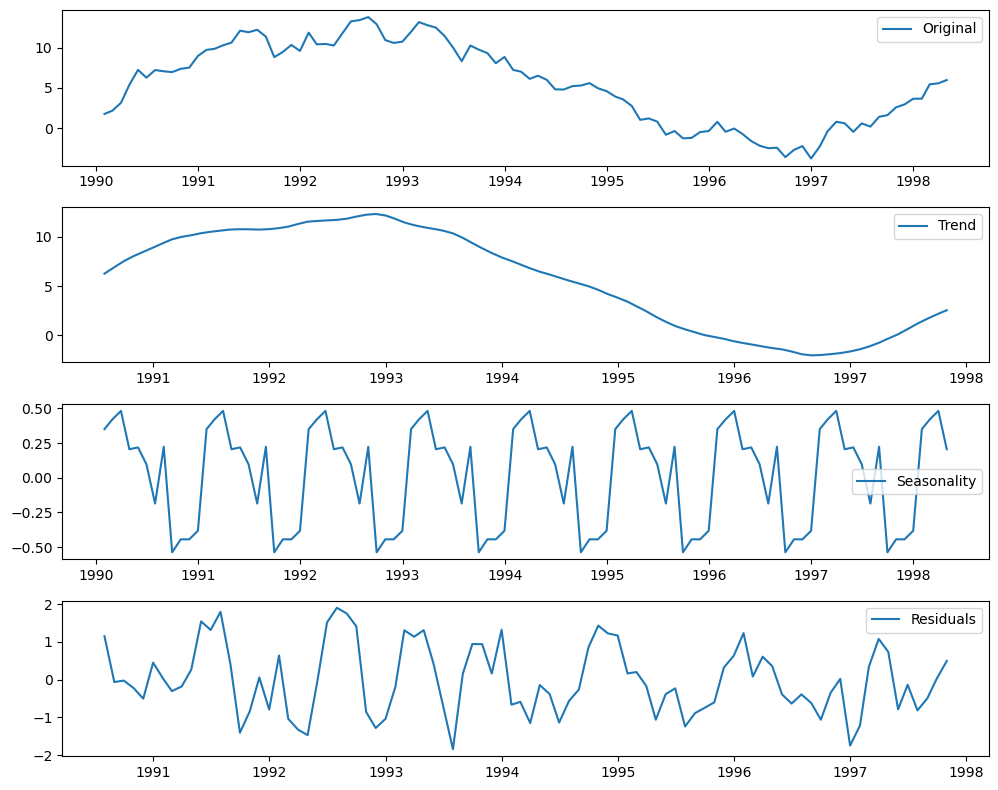

In [158]:
#Decompose the time series into trend, seasonality, and residual components
decomposition = sm.tsa.seasonal_decompose(df['Value'], model='additive') #Or model = multiplicative
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df['Value'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [73]:
#Augmented Dickey Fuller test for stationarity 
#H0: Time series contains a unit root and is non-stationary, HA: Time series does not contain a unit root and is stationary
#If adf_stat < adf_cv, reject the null / If p-value < alpha, reject the null
adf_result = adfuller(values)
adf_stat = adf_result[0]
adf_p_value = adf_result[1]
five_pct_cv = adf_result[4].get('5%') #adf_result[4] is a dictionary of alpha and cv


if adf_p_value < 0.05:
    print('Reject the Null - The data are probably stationary')
else:
    print('Do not reject the null - The data are probably not stationary.')
    
if adf_stat < five_pct_cv:
    print('Reject the null - The data are probably stationary')
else:
    print('Do not reject the null - The data are probably not stationary.')
    
    
def adf_test(values, alpha):
    adf_result = adfuller(values)
    adf_p_value = adf_result[1]
    
    if adf_p_value < alpha:
        print('Reject the Null - The data are probably stationary')
    elif adf_p_value > alpha:
        print('Do not reject the null - The data are probably not stationary.')   

Do not reject the null - The data are probably not stationary.
Do not reject the null - The data are probably not stationary.


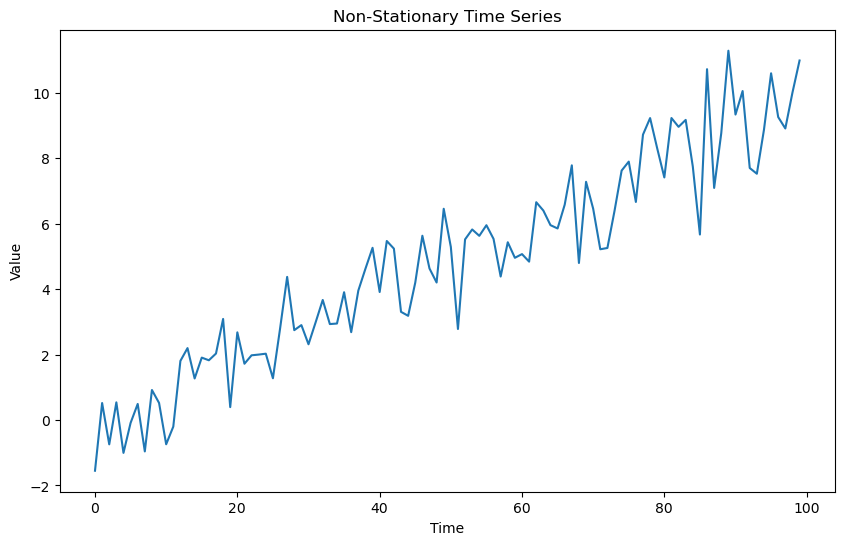

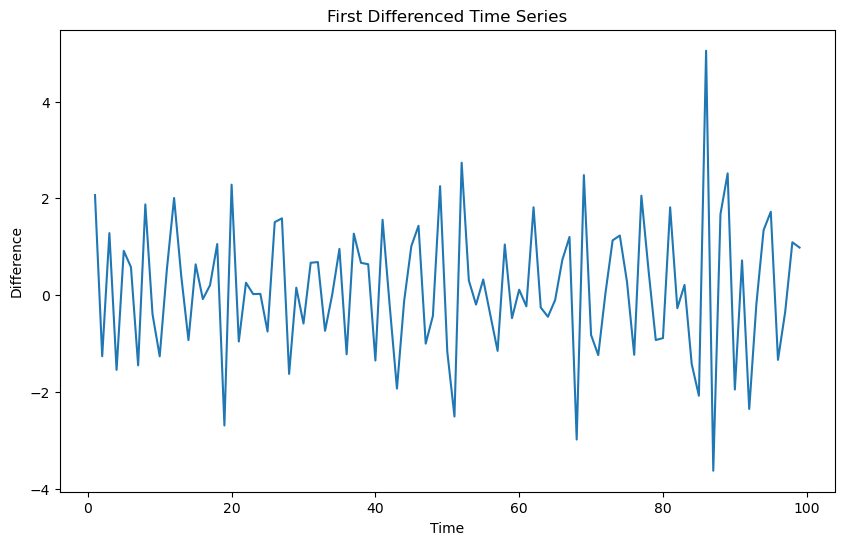

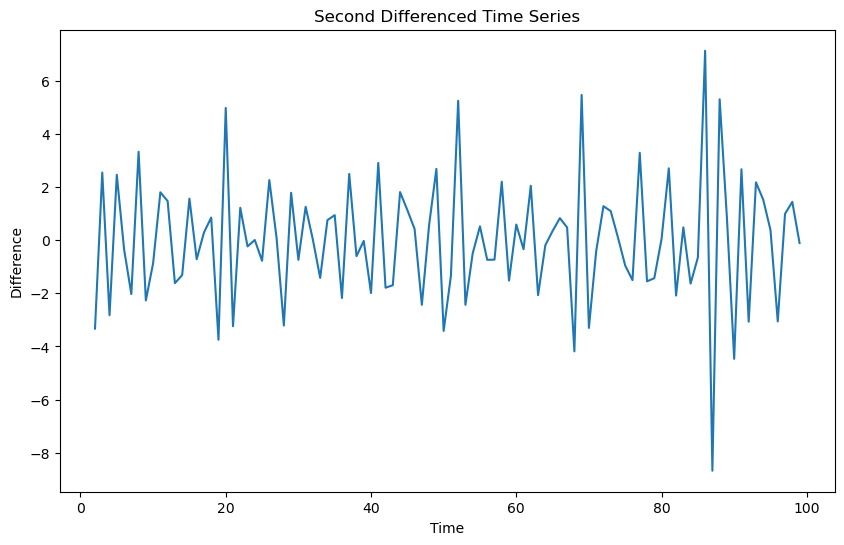

In [84]:
#Differencing
#Generate non-stationary time series
time = np.arange(0, 100, 1)
trend = 0.1 * time
noise = np.random.randn(len(time))
non_stationary_data = trend + noise

#Plot the non-stationary data
plt.figure(figsize=(10, 6))
plt.plot(time, non_stationary_data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Non-Stationary Time Series')
plt.show()

#Calculate and plot the first differenced series
differenced_data = np.diff(non_stationary_data)
plt.figure(figsize=(10, 6))
plt.plot(time[1:], differenced_data) #Since one less value post-differencing
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('First Differenced Time Series')
plt.show()

#Calculate and plot the second differenced series
differenced_data_2 = np.diff(differenced_data)
plt.figure(figsize=(10, 6))
plt.plot(time[2:], differenced_data_2) #Since one less value post-differencing
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Second Differenced Time Series')
plt.show()

In [85]:
adf_test(non_stationary_data, 0.05)
adf_test(differenced_data, 0.05)

Do not reject the null - The data are probably not stationary.
Reject the Null - The data are probably stationary


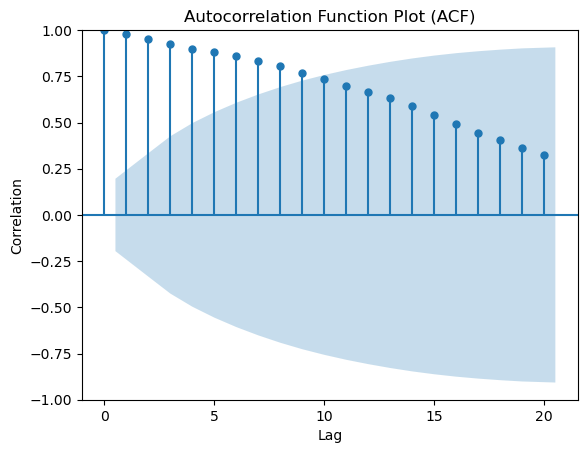

In [76]:
#ACF Plot
sm.graphics.tsa.plot_acf(df['Value'].values)
#sm.graphics.tsa.plot_acf(df['Value'].values, lags=30)
plt.title('Autocorrelation Function Plot (ACF)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

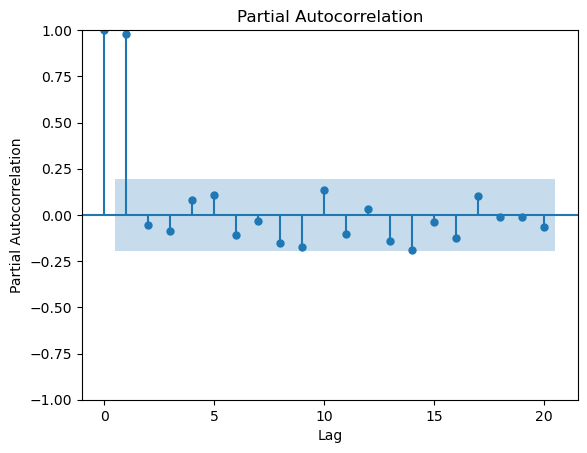

In [77]:
#PACF Plot
sm.graphics.tsa.plot_pacf(df['Value'].values)
#sm.graphics.tsa.plot_pacf(df['Value'].values, lags=30)
plt.title('Partial Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

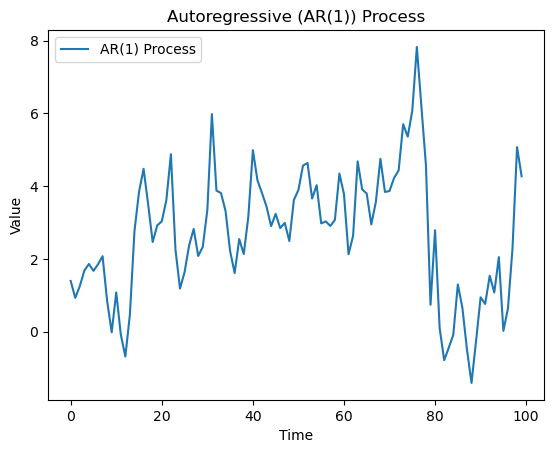

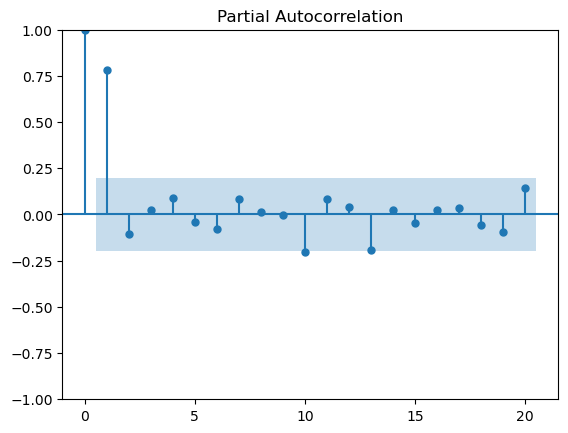

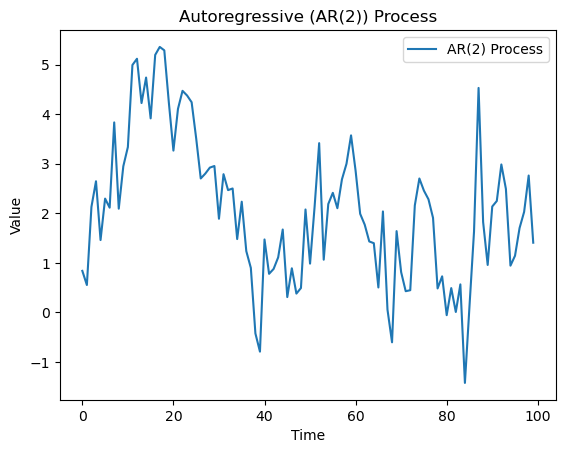

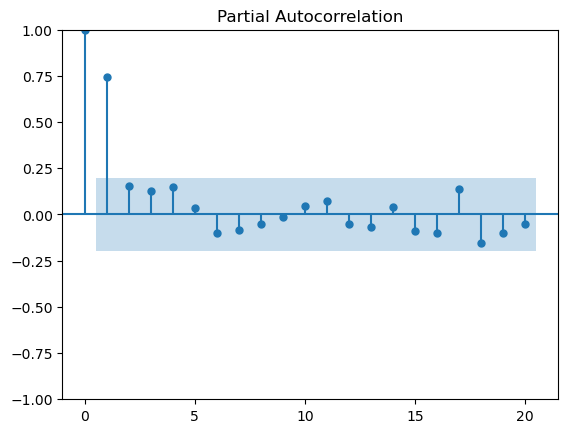

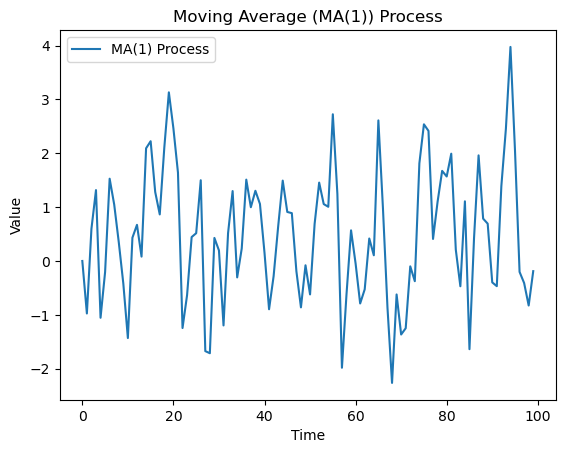

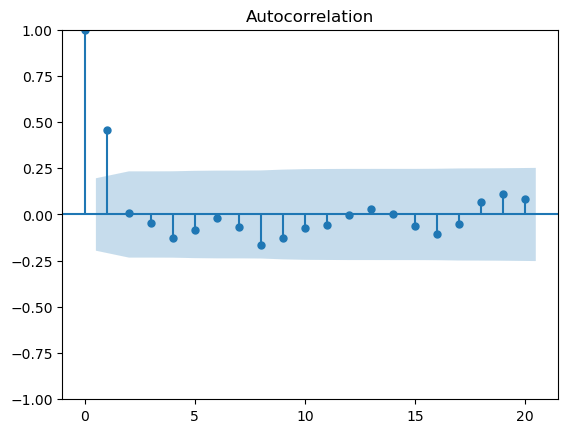

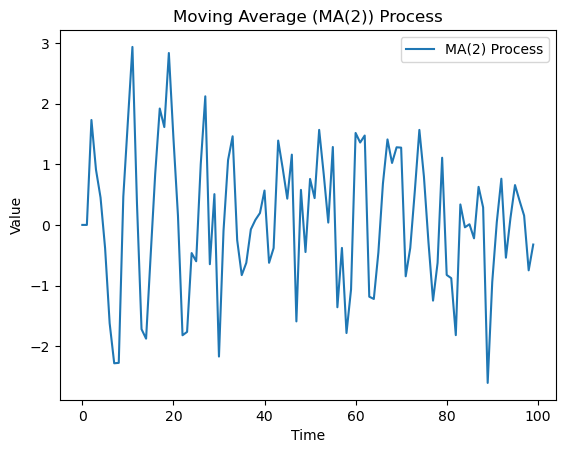

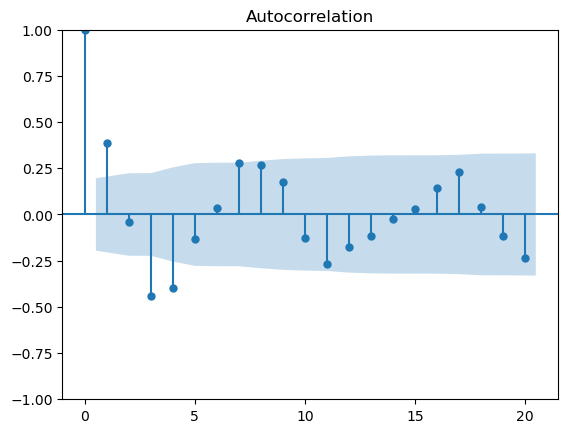

In [160]:
df = pd.read_csv('ARandMA.csv')
df.head()

Y_AR_1 = df['AR1']
Y_AR_2 = df['AR2']
Y_MA_1 = df['MA1']
Y_MA_2 = df['MA2']

plt.plot(Y_AR_1, label='AR(1) Process')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Autoregressive (AR(1)) Process')
plt.legend()
plt.show()

sm.graphics.tsa.plot_pacf(Y_AR_1)
plt.show()

plt.plot(Y_AR_2, label='AR(2) Process')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Autoregressive (AR(2)) Process')
plt.legend()
plt.show()

sm.graphics.tsa.plot_pacf(Y_AR_2)
plt.show()

plt.plot(Y_MA_1, label='MA(1) Process')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Moving Average (MA(1)) Process')
plt.legend()
plt.show()

sm.graphics.tsa.plot_acf(Y_MA_1)
plt.show()

plt.plot(Y_MA_2, label='MA(2) Process')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Moving Average (MA(2)) Process')
plt.legend()
plt.show()

sm.graphics.tsa.plot_acf(Y_MA_2)
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                    AR1   No. Observations:                  100
Model:                     AutoReg(1)   Log Likelihood                -148.026
Method:               Conditional MLE   S.D. of innovations              1.079
Date:                Fri, 22 Mar 2024   AIC                            302.052
Time:                        15:36:45   BIC                            309.837
Sample:                             1   HQIC                           305.202
                                  100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5885      0.198      2.979      0.003       0.201       0.976
AR1.L1         0.7909      0.062     12.814      0.000       0.670       0.912
                                    Roots           

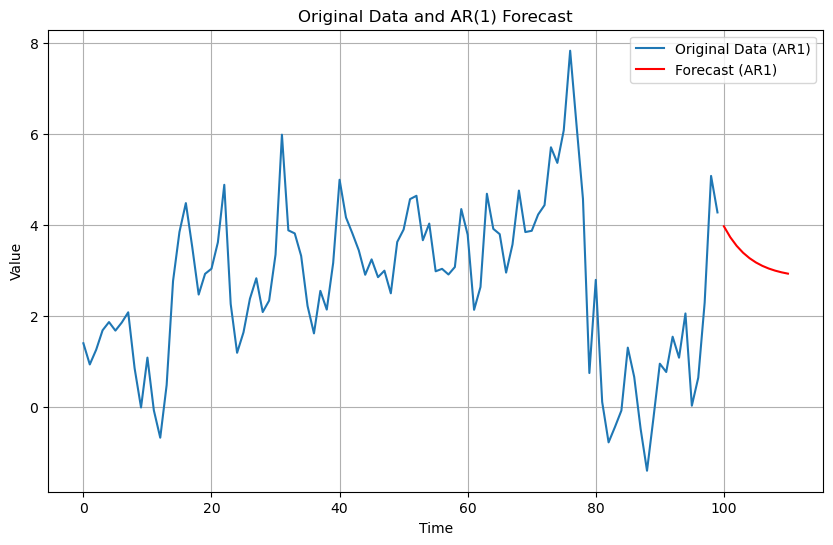

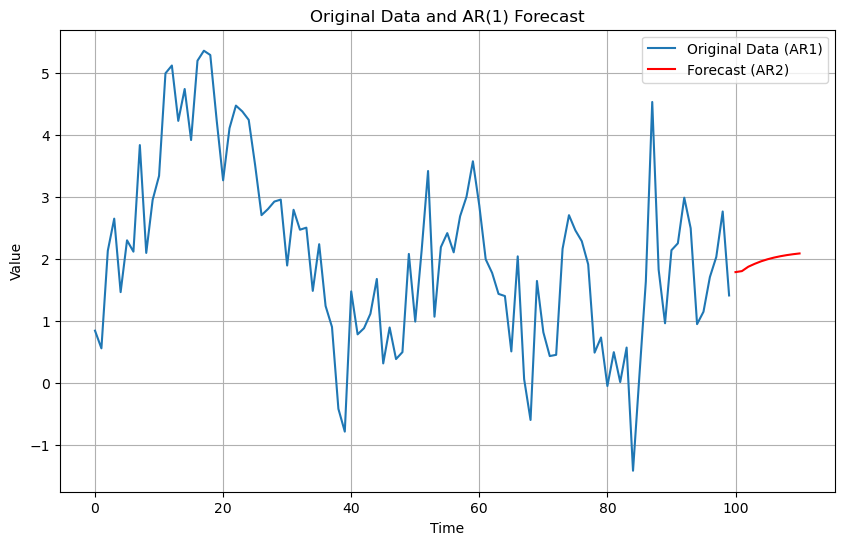

In [116]:
#AR1 model 
AR_1_Model = AutoReg(Y_AR_1, lags=1)
AR_1_Results = ar1_model.fit()
print(AR_1_Results.summary())
Forecast_AR_1 = AR_1_Results.predict(start=len(Yar1), end=len(Yar1) + 10)

plt.figure(figsize=(10, 6))
plt.plot(Y_AR_1, label='Original Data (AR1)')
plt.plot(np.arange(len(Y_AR_1), len(Y_AR_1) + len(Forecast_AR_1)), Forecast_AR_1, color='red', label='Forecast (AR1)')
plt.title('Original Data and AR(1) Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#AR2 model
AR_2_Model = AutoReg(Y_AR_2, lags=2)
AR_2_Results = AR_2_Model.fit()
AR_2_Results.summary()
Forecast_AR_2 = AR_2_Results.predict(start=len(Y_AR_2), end=len(Y_AR_2) + 10)

plt.figure(figsize=(10, 6))
plt.plot(Y_AR_2, label='Original Data (AR1)')
plt.plot(np.arange(len(Y_AR_2), len(Y_AR_2) + len(Forecast_AR_2)), Forecast_AR_2, color='red', label='Forecast (AR2)')
plt.title('Original Data and AR(1) Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                    MA1   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -145.654
Date:                Fri, 22 Mar 2024   AIC                            297.309
Time:                        15:43:17   BIC                            305.124
Sample:                             0   HQIC                           300.472
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4819      0.172      2.802      0.005       0.145       0.819
ma.L1          0.6422      0.091      7.092      0.000       0.465       0.820
sigma2         1.0724      0.142      7.527      0.0

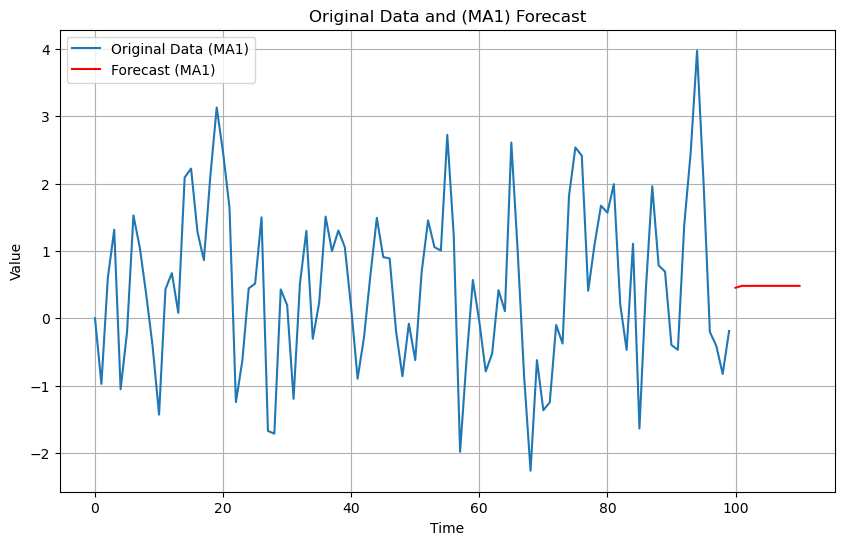

100   -0.215086
101    0.070577
102    0.076249
103    0.076249
104    0.076249
105    0.076249
Name: predicted_mean, dtype: float64


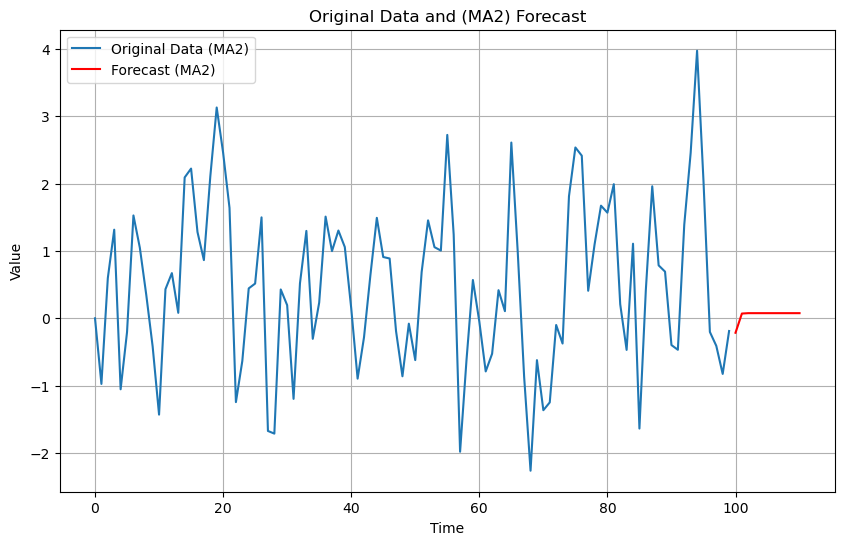

In [130]:
#MA1 Model
MA_1_Model = ARIMA(Y_MA_1, order=(0, 0, 1))
MA_1_Results = MA_1_Model.fit()
print(MA_1_Results.summary())
Forecast_MA_1 = MA_1_Results.predict(start=len(Y_MA_1), end=len(Y_MA_1) + 10)
print(forecast)

plt.figure(figsize=(10, 6))
plt.plot(Y_MA_1, label='Original Data (MA1)')
plt.plot(np.arange(len(Y_MA_1), len(Y_MA_1) + len(Forecast_MA_1)), Forecast_MA_1, color='red', label='Forecast (MA1)')
plt.title('Original Data and (MA1) Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#MA2 Model
MA_2_Model = ARIMA(Y_MA_2, order=(0, 0, 2))
MA_2_Results = MA_2_Model.fit()
MA_2_Results.summary()
Forecast_MA_2 = MA_2_Results.predict(start=len(Y_MA_2), end=len(Y_MA_2) + 10)
print(forecast)

plt.figure(figsize=(10, 6))
plt.plot(Y_MA_1, label='Original Data (MA2)')
plt.plot(np.arange(len(Y_MA_2), len(Y_MA_2) + len(Forecast_MA_2)), Forecast_MA_2, color='red', label='Forecast (MA2)')
plt.title('Original Data and (MA2) Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

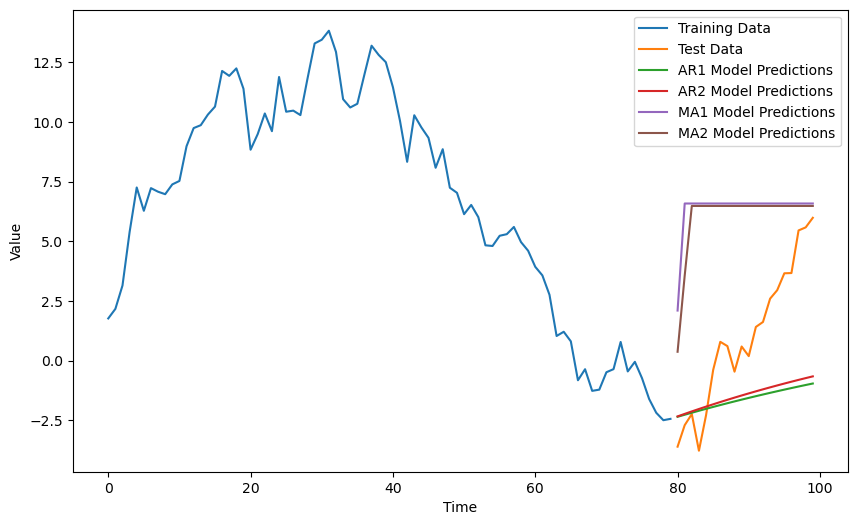

In [166]:
data = df['Value']

#Split the data into training and testing sets
train_size = int(0.8 * n)
train_data = data[:train_size]
test_data = data[train_size:]

#Fit the AR1 model to the training data
order = (1, 0, 0)  #ARIMA(p, d, q) 
ar1_model = ARIMA(train_data, order=order)
ar1_model_results = ar1_model.fit()

#Fit the AR2 model to the training data
order = (2, 0, 0)  #ARIMA(p, d, q) 
ar2_model = ARIMA(train_data, order=order)
ar2_model_results = ar2_model.fit()

#Fit the MA1 model to the training data
order = (0, 0, 1)  # ARIMA(p, d, q) order
ma1_model = ARIMA(train_data, order=order)
ma1_model_results = ma1_model.fit()

#Fit the MA2 model to the training data
order = (0, 0, 2)  # ARIMA(p, d, q) order
ma2_model = ARIMA(train_data, order=order)
ma2_model_results = ma2_model.fit()

#Make predictions on the test data
ar1_predictions = ar1_model_results.predict(start=train_size, end=n-1)
ar2_predictions = ar2_model_results.predict(start=train_size, end=n-1)
ma1_predictions = ma1_model_results.predict(start=train_size, end=n-1)
ma2_predictions = ma2_model_results.predict(start=train_size, end=n-1)


#Plot the original data and predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(train_size), train_data, label='Training Data')
plt.plot(range(train_size, n), test_data, label='Test Data')
plt.plot(range(train_size, n), ar1_predictions, label='AR1 Model Predictions')
plt.plot(range(train_size, n), ar2_predictions, label='AR2 Model Predictions')
plt.plot(range(train_size, n), ma1_predictions, label='MA1 Model Predictions')
plt.plot(range(train_size, n), ma2_predictions, label='MA2 Model Predictions')


plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -142.249
Date:                Fri, 22 Mar 2024   AIC                            292.499
Time:                        16:12:13   BIC                            302.919
Sample:                    01-31-1990   HQIC                           296.716
                         - 04-30-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8431      3.440      1.408      0.159      -1.900      11.586
ar.L1          0.9722      0.021     46.478      0.000       0.931       1.013
ma.L1          0.0623      0.097      0.640      0.5

/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


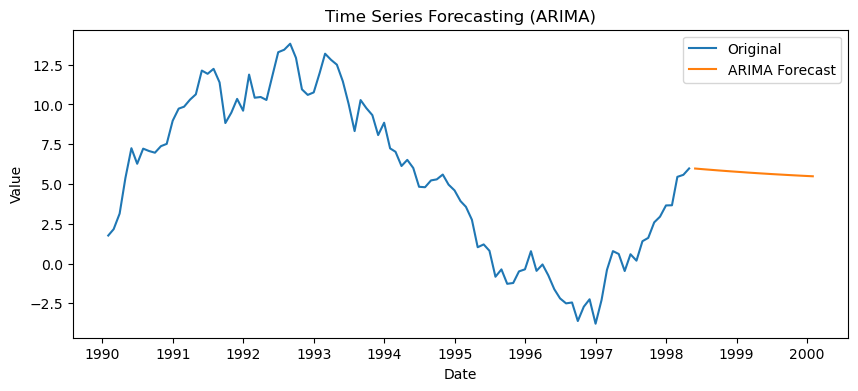

In [21]:
#Perform time series forecasting using ARIMA model
model = sm.tsa.ARIMA(df['Value'], order=(1, 0, 1))
results = model.fit()
print(results.summary())
forecast = results.predict(start=100, end=120)

#Plot the original data and the forecasted values
plt.figure(figsize=(10, 4))
plt.plot(df['Value'], label='Original')
plt.plot(forecast, label='ARIMA Forecast')
plt.title('Time Series Forecasting (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()

/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=284.598, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=286.152, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=286.239, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=282.778, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=285.758, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.142 seconds
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  100
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -140.389
Date:                Fri, 22 Mar 2024   AIC                            282.778
Time:                        16:13:44   BIC                            285.373
Sample:                    01-31-1990   HQIC                           283.828
                    

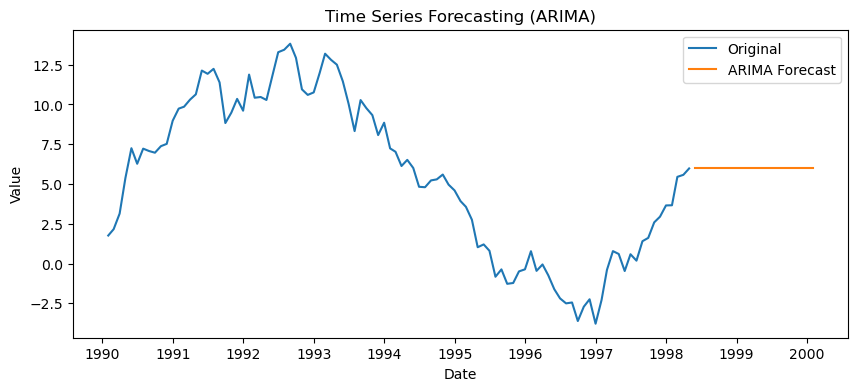

In [27]:
#Auto ARIMA Model Selection
import pmdarima as pm

def auto_arima(data, seasonal=False, m=12, trace=True):
    arima_model = pm.auto_arima(data, seasonal=seasonal, m=m, trace=trace)
    return arima_model
arima_model = auto_arima(df['Value'])

model = sm.tsa.ARIMA(df['Value'], order=(0, 1, 0))
results = model.fit()
print(results.summary())
forecast = results.predict(start=100, end=120)

#Plot the original data and the forecasted values
plt.figure(figsize=(10, 4))
plt.plot(df['Value'], label='Original')
plt.plot(forecast, label='ARIMA Forecast')
plt.title('Time Series Forecasting (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44986D+00    |proj g|=  1.09358D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      6      1     0     0   4.154D-06   1.445D+00
  F =   1.4454439729405930     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/robertwrobel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


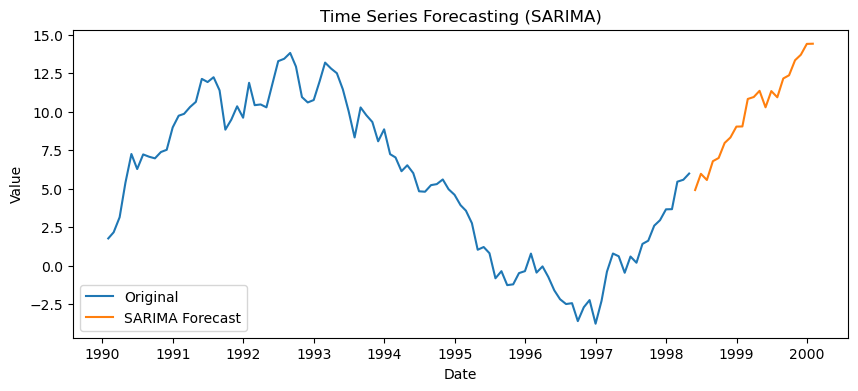

In [29]:
#Perform time series forecasting using SARIMA model
model_sarima = sm.tsa.SARIMAX(df['Value'], order=(0, 1, 0), seasonal_order=(0, 1, 0, 12))
results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.predict(start=100, end=120)

#Plot the original data and the SARIMA forecasted values
plt.figure(figsize=(10, 4))
plt.plot(df['Value'], label='Original')
plt.plot(forecast_sarima, label='SARIMA Forecast')
plt.title('Time Series Forecasting (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()

In [21]:
#Imputing Missing Values
#Resampling
#ARIMAX
#VAR